# Object Detectors with Dlib

In [1]:
import cv2
import dlib
import os
import sys
import glob

from skimage import io 
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
%matplotlib inline

import numpy as np

## Face Detection

I briefly explored the following two face detectors included in the [dlib](http://dlib.net/) library:

1. HOG-based: `get_frontal_face_detector`
    * uses the classic Histogram of Oriented Gradients (HOG) feature combined with a linear classifier, an image pyramid, and sliding window detection scheme
    * estimates the location of 68 (x,y)-coordinates of the face regions such as eyebrows, eyes, jawline, lips, etc.
    
2. CNN-based: `cnn_face_detector`
    * much more accurate than the HOG-based model but also takes much more computational power to run (intended to be executed on a GPU)

In [2]:
for f in sorted(glob.glob(os.path.join('face_det_pics', '*.jpg'))):
    img = Image.open(f)
    # flip horizontal pics to vertical
    if img.size[1] < img.size[0]:
        img = img.transpose(Image.ROTATE_270)
    # downsize image using PIL's convenient thumbnail function
    img.thumbnail([1200, 1200], Image.ANTIALIAS)
    img.save(f)

In [3]:
hog_detector = dlib.get_frontal_face_detector()
hog_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

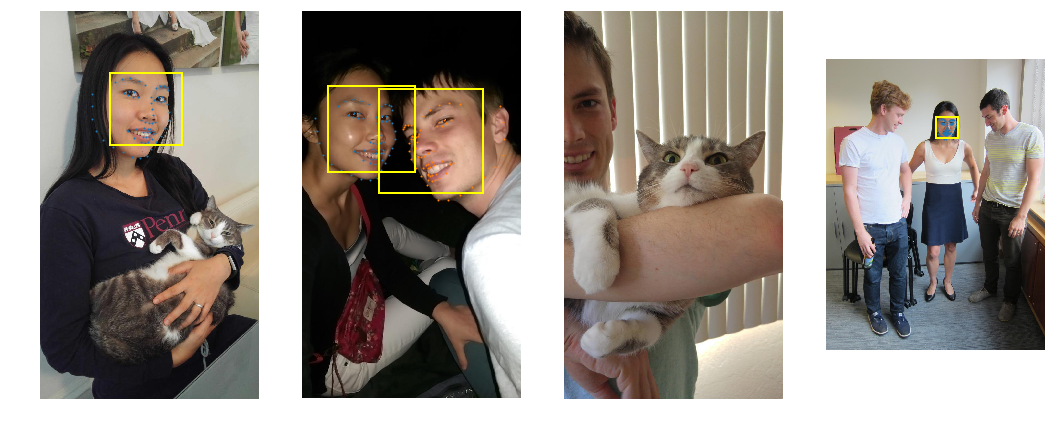

In [4]:
img1 = cv2.imread('face_det_pics/face_ex1.jpg')
img2 = cv2.imread('face_det_pics/face_ex2.jpg')
img3 = cv2.imread('face_det_pics/face_ex3.jpg')
img4 = cv2.imread('face_det_pics/face_ex4.jpg')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 10))

for img, ax in zip([img1, img2, img3, img4], [ax1, ax2, ax3, ax4]):
    # OpenCV's default color order is BGR, whereas matplotlib uses RGB
    # need to explicitly convert back to RGB when plotting in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    
    dets = hog_detector(img, 1)
    
    # for each detected face
    for d in dets:
        # draw bounding box of the detected face
        rect = patches.Rectangle((d.left(), d.top()), d.width(), d.height(), fill=False, color='yellow', linewidth=2)
        ax.add_patch(rect)

        # draw landmarks
        parts = hog_predictor(img, d).parts()
        ax.scatter([point.x for point in parts], [point.y for point in parts], s=1)

        # number the landmarks
        #for k, point in enumerate(parts):
        #    ax.text(point.x, point.y, k, fontsize=5)

Limitation with HOG-based model 
* Works fine in obvious cases and also when faces are slightly turned
* Can't detect half a face
* As the name `get_frontal_detector` suggests, it can't detect the face in profile (from the side)

In [5]:
cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')

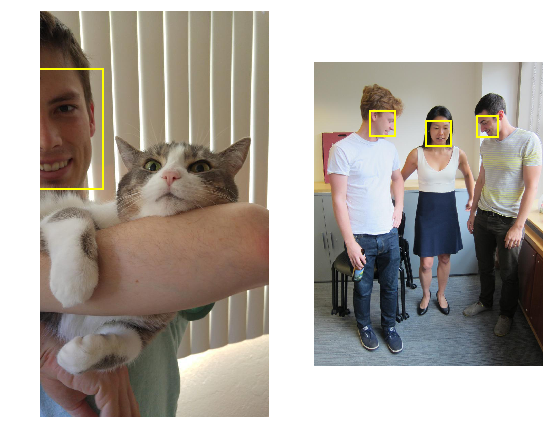

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,10))

for img, ax in zip([img3, img4], [ax1, ax2]):
    # OpenCV's default color order is BGR, whereas matplotlib uses RGB
    # need to explicitly convert back to RGB when plotting in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    
    dets = cnn_face_detector(img, 1)

    # for each detected face
    for d in dets:
        # draw bounding box of the detected face
        rect = patches.Rectangle((d.rect.left(), d.rect.top()), d.rect.width(), d.rect.height(), 
                                 fill=False, color='yellow', linewidth=2)
        ax.add_patch(rect)

CNN-based model can detect the faces that the HOG-based model failed to detect
* Definiely more accurate, but also much slower

## Meow Detector

With dlib's `train_simple_object_detector`, I trained a crude HOG-based object detector from scratch for detecting my cat's frontal face.
I followed the guide [here](http://dlib.net/train_object_detector.py.html).

In [7]:
# downsize training images
# 78 training images in total
for f in glob.glob(os.path.join('/home/darby/Downloads/dlib_train/', '*.jpg')):
    img = Image.open(f)
    img.thumbnail([1200, 1200], Image.ANTIALIAS)
    img.save(f)

In [8]:
# options for trainng
options = dlib.simple_object_detector_training_options()
options.add_left_right_image_flips = True # faces are symmetric
options.C = 8 # SVM C paramter
options.num_threads = 4 # number of CPU cores
options.be_verbose = True

The training dataset requires an XML file that lists the images used for training as well as the positions of the detection boxes.
Following the instructions [here](https://github.com/davisking/dlib/tree/master/tools/imglab), I used the `imglab` tool that came with `dlib` to manually draw a bounding box in each training image and to create the required XML input.

As you can imagine, this part is quite tedious.

In [9]:
# Actual training 
# save the final detector to meow.svm
'''
training_xml_path = os.path.join('/home/darby/Downloads/dlib_train/', 'meowset.xml')
dlib.train_simple_object_detector(training_xml_path, 'meow.svm', options)
'''

"\ntraining_xml_path = os.path.join('/home/darby/Downloads/dlib_train/', 'meowset.xml')\ndlib.train_simple_object_detector(training_xml_path, 'meow.svm', options)\n"

In [10]:
# load the trained detector
meowtector = dlib.simple_object_detector('meow.svm')

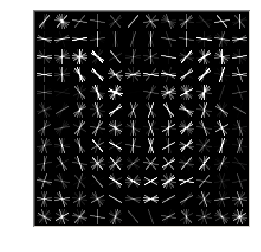

In [11]:
# take a look at the HOG filter - this will pop up the image in a new window
'''
win_det = dlib.image_window()
win_det.set_image(meowtector)
'''

# this is what the learned HOG filter looks like - which definitely looks like a cat's face
plt.imshow(Image.open('HOGfilter_screenshot.png'))
plt.axis('off');

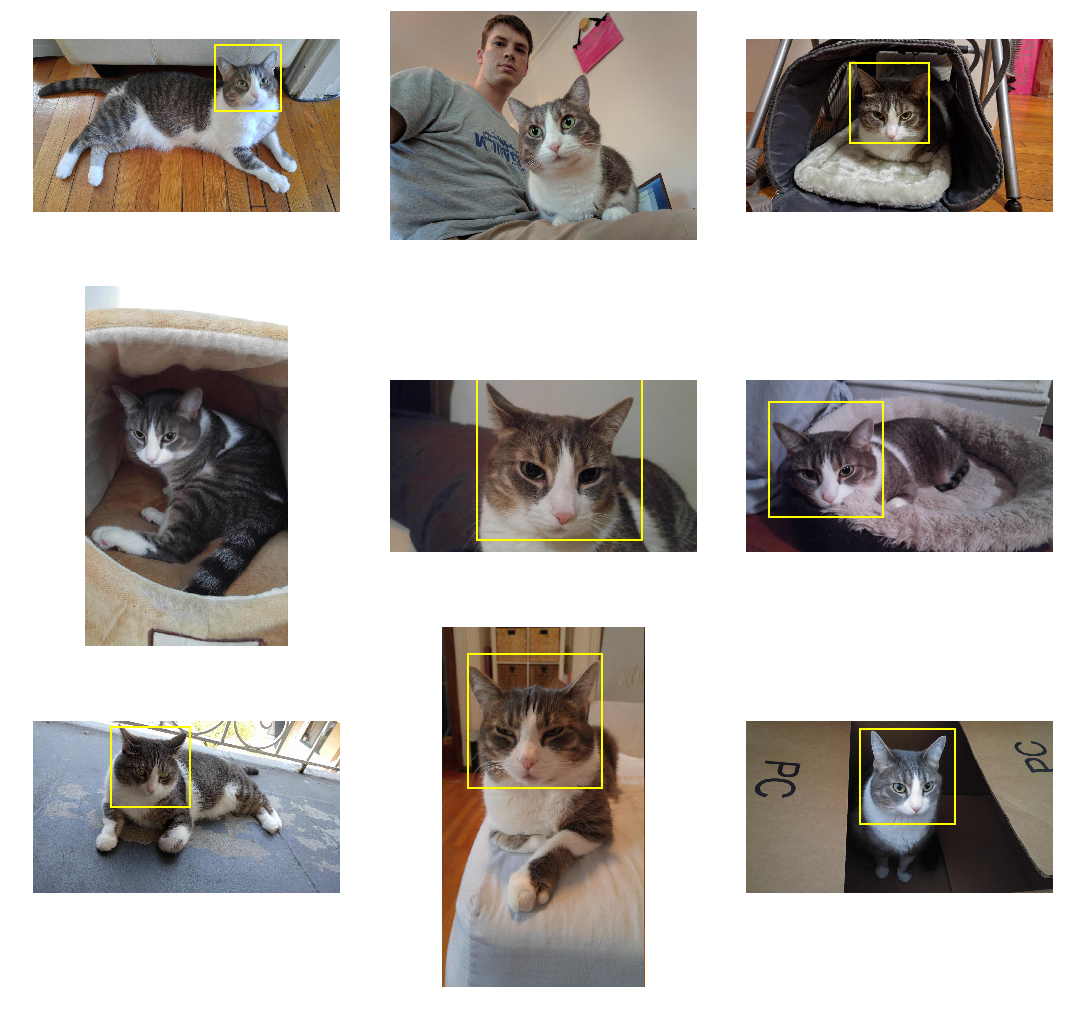

In [12]:
dlib_test_meow = '/home/darby/Downloads/dlib_test_meow/'

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

axes = ['ax{}'.format(i) for i in np.arange(9)]
for i in np.arange(3):
    axes[i] = plt.subplot(gs[0,i])
for i in np.arange(3, 6):
    axes[i] = plt.subplot(gs[1,i-3])
for i in np.arange(6, 9):
    axes[i] = plt.subplot(gs[2,i-6])

for ax, f in zip(axes, glob.glob(os.path.join(dlib_test_meow, '*.jpg'))):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    
    dets = meowtector(img)
    for d in dets:
        rect = patches.Rectangle((d.left(), d.top()), d.width(), d.height(), fill=False, color='yellow', linewidth=2)
        ax.add_patch(rect)
        
gs.tight_layout(fig)

The crude detector does a decent job of detecting my cat's face when she's facing the camera, and it can handle variations in angles / tilting of the face to a small extent.

I've also tested live detection of my cat via webcam, the excerpt from which is displayed in the README file. The script for running (and potentially saving the video output) is provided in the repo.

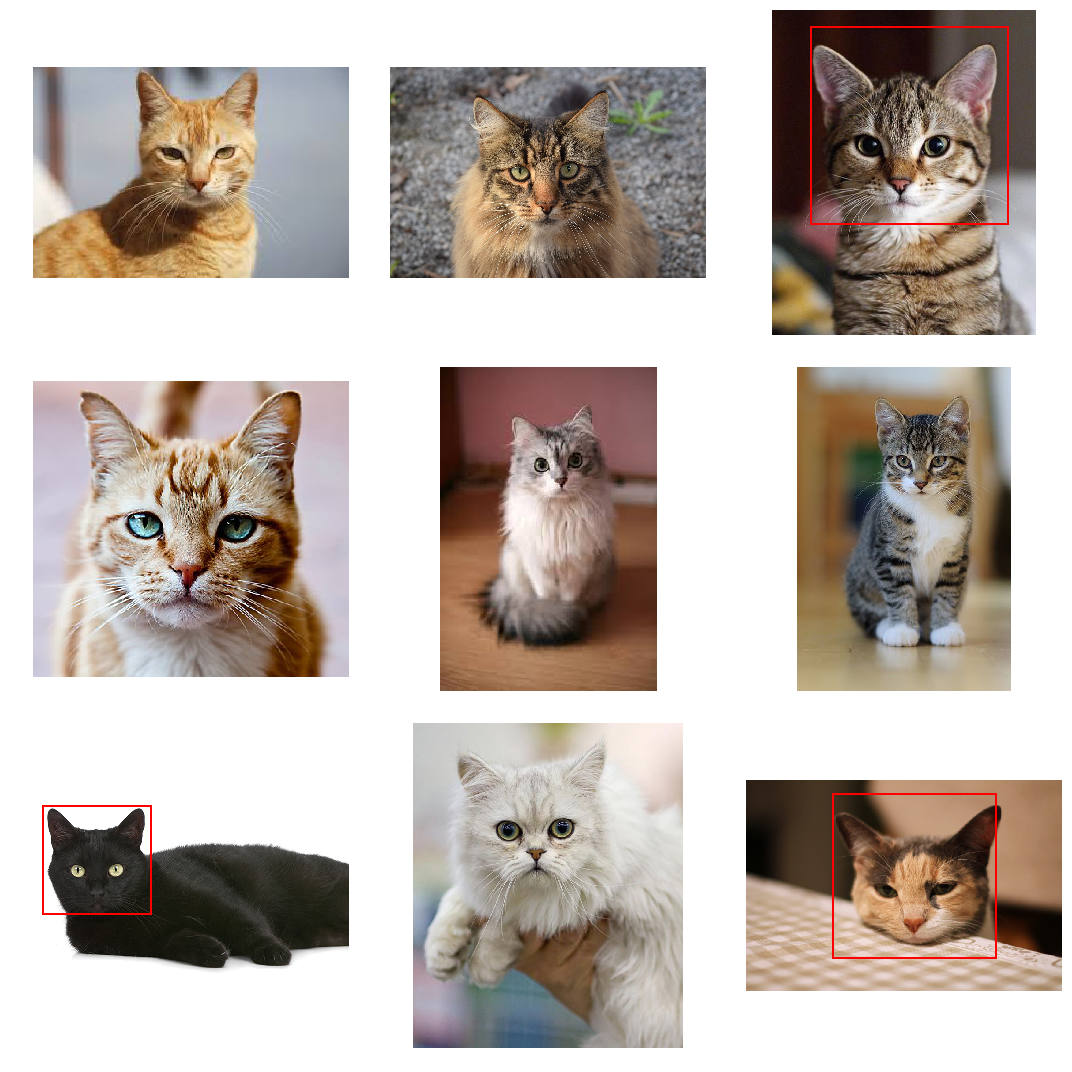

In [13]:
dlib_test_notmeow = '/home/darby/Downloads/dlib_test_notmeow/'

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

axes = ['ax{}'.format(i) for i in np.arange(9)]
for i in np.arange(3):
    axes[i] = plt.subplot(gs[0,i])
for i in np.arange(3, 6):
    axes[i] = plt.subplot(gs[1,i-3])
for i in np.arange(6, 9):
    axes[i] = plt.subplot(gs[2,i-6])

for ax, f in zip(axes, glob.glob(os.path.join(dlib_test_notmeow, '*.jpg'))):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    
    dets = meowtector(img)
    for d in dets:
        rect = patches.Rectangle((d.left(), d.top()), d.width(), d.height(), fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        
gs.tight_layout(fig)

False positives:
* Of the carefully selected images where cats are more or less staring directly into the camera, the ones where face shapes are most similar to my cat appear to be detected
* The detector does display some selectively in detecting the faces

Considering that this crude detector was trained from scratch on only 78 training images, it's not so bad.
However, the technique of HOG is by nature very limited.